A 250-hPa Hemispheric Map using Python
======================================

This example plots a hemispheric plot of GFS 250-hPa Geopotential Heights and
wind speed in knots.

In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS

# Latest GFS Dataset
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/latest.xml')
best_ds = list(cat.datasets.values())[0]
ncss = NCSS(best_ds.access_urls['NetcdfSubset'])

# Set the time to current
now = datetime.utcnow()

# Query for Latest GFS Run
gfsdata_hght = ncss.query().time(now).accept('netcdf4')
gfsdata_hght.variables('Geopotential_height_isobaric').add_lonlat()

# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat,south_lat,east_lon,west_lon)
gfsdata_hght.lonlat_box(0, 360, 0, 90)

# Set desired level 50000 = 50000 Pa = 500 hPa
gfsdata_hght.vertical_level(25000)

# Actually getting the data
data_hght = ncss.get_data(gfsdata_hght)

# Query for Latest GFS Run
gfsdata_wind = ncss.query().time(now).accept('netcdf4')
gfsdata_wind.variables('u-component_of_wind_isobaric',
                       'v-component_of_wind_isobaric').add_lonlat()

# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat,south_lat,east_lon,west_lon)
gfsdata_wind.lonlat_box(0, 360, 0, 90)

# Set desired level 50000 = 50000 Pa = 500 hPa
gfsdata_wind.vertical_level(25000)

# Actually getting the data
data_wind = ncss.get_data(gfsdata_wind)

The next cell will take the downloaded data and parse it to different variables
for use later on. Add a cyclic point using the cartopy utility add_cyclic_point
to the longitudes (the cyclic dimension) as well as any data that is being
contoured or filled.

In [2]:
dtime = data_hght.variables['Geopotential_height_isobaric'].dimensions[0]
dlat = data_hght.variables['Geopotential_height_isobaric'].dimensions[2]
dlon = data_hght.variables['Geopotential_height_isobaric'].dimensions[3]
lat = data_hght.variables[dlat][:]
lon = data_hght.variables[dlon][:]

# Converting times using the num2date function available through netCDF4
times = data_hght.variables[dtime]
vtimes = num2date(times[:], times.units)

# Smooth the 250-hPa heights using a gaussian filter from scipy.ndimage
hgt_250, lon = cutil.add_cyclic_point(data_hght.variables['Geopotential_height_isobaric'][:],
                                      coord=lon)
Z_250 = ndimage.gaussian_filter(hgt_250[0, 0, :, :], sigma=3, order=0)

u250 = (units(data_wind.variables['u-component_of_wind_isobaric'].units) *
        data_wind.variables['u-component_of_wind_isobaric'][0, 0, :, :])
v250 = (units(data_wind.variables['v-component_of_wind_isobaric'].units) *
        data_wind.variables['v-component_of_wind_isobaric'][0, 0, :, :])
u250 = u250.units * cutil.add_cyclic_point(u250)
v250 = v250.units * cutil.add_cyclic_point(v250)
wspd250 = mpcalc.wind_speed(u250, v250).to('knots')

The next cell sets up the geographic details for the plot that we are going to do later.
This is done using the Cartopy package. We will also bring in some geographic data to
geo-reference the image for us.

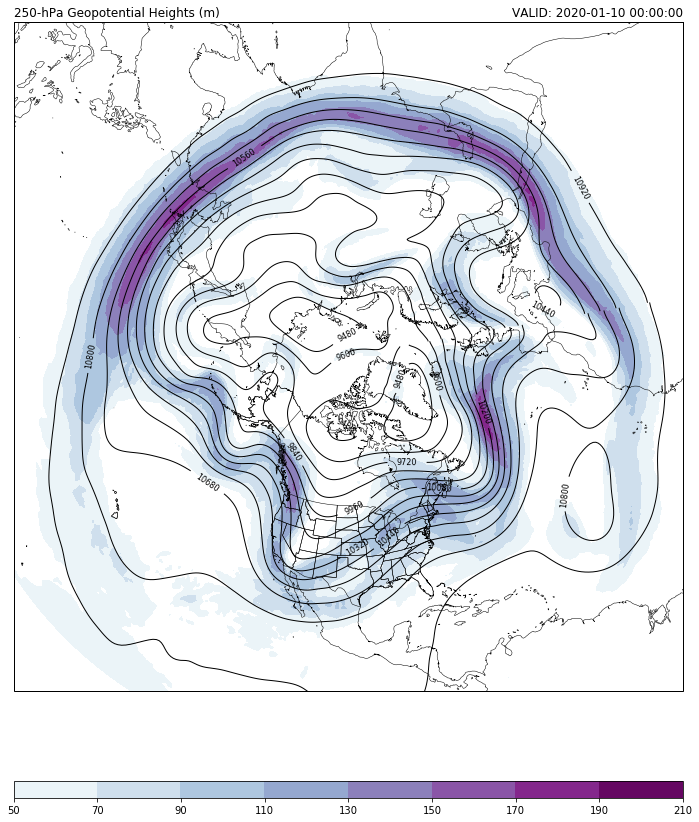

In [3]:
datacrs = ccrs.PlateCarree()
plotcrs = ccrs.NorthPolarStereo(central_longitude=-100.0)

# Make a grid of lat/lon values to use for plotting with Basemap.
lons, lats = np.meshgrid(lon, lat)

fig = plt.figure(1, figsize=(12., 13.))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, .02],
                       bottom=.07, top=.99, hspace=0.01, wspace=0.01)

ax = plt.subplot(gs[0], projection=plotcrs)
ax.set_title('250-hPa Geopotential Heights (m)', loc='left')
ax.set_title('VALID: {}'.format(vtimes[0]), loc='right')

#   ax.set_extent([west long, east long, south lat, north lat])
ax.set_extent([-180, 180, 10, 90], ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.STATES, linewidth=0.5)

clev250 = np.arange(9000, 12000, 120)
cs = ax.contour(lons, lats, Z_250, clev250, colors='k',
                linewidths=1.0, linestyles='solid', transform=datacrs)
plt.clabel(cs, fontsize=8, inline=1, inline_spacing=10, fmt='%i',
           rightside_up=True, use_clabeltext=True)

clevsped250 = np.arange(50, 230, 20)
cmap = plt.cm.get_cmap('BuPu')
cf = ax.contourf(lons, lats, wspd250, clevsped250, cmap=cmap, transform=datacrs)
cax = plt.subplot(gs[1])
cbar = plt.colorbar(cf, cax=cax, orientation='horizontal', extend='max', extendrect=True)